# Importing Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import yfinance as yf
from datetime import date
import datetime 

# Helper Functions

In [2]:
def retrive_data(company):
    start_date = '2010-01-01' # Setting a static start date
    end_date = date.today() # End date is today
    data = yf.download(company, start_date, end_date)
    data = data[["Close"]] #We only require the closeing price for the stock and the date which is the index
    return data



In [3]:
data = retrive_data('AAPL') # Getting the data for Apple

[*********************100%***********************]  1 of 1 completed


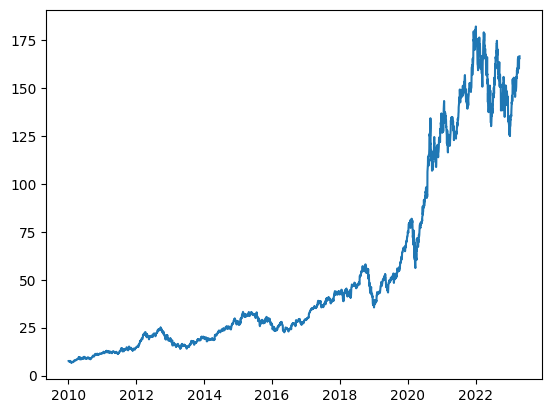

In [4]:
plt.plot(data.index, data["Close"])

In [5]:
df = data.copy()

In [6]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,123.389999,122.540001,120.089996,120.589996
1,2021-03-26,122.540001,120.089996,120.589996,121.209999
2,2021-03-29,120.089996,120.589996,121.209999,121.389999
3,2021-03-30,120.589996,121.209999,121.389999,119.900002
4,2021-03-31,121.209999,121.389999,119.900002,122.150002
...,...,...,...,...,...
247,2022-03-17,150.619995,155.089996,159.589996,160.619995
248,2022-03-18,155.089996,159.589996,160.619995,163.979996
249,2022-03-21,159.589996,160.619995,163.979996,165.380005
250,2022-03-22,160.619995,163.979996,165.380005,168.820007


In [7]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

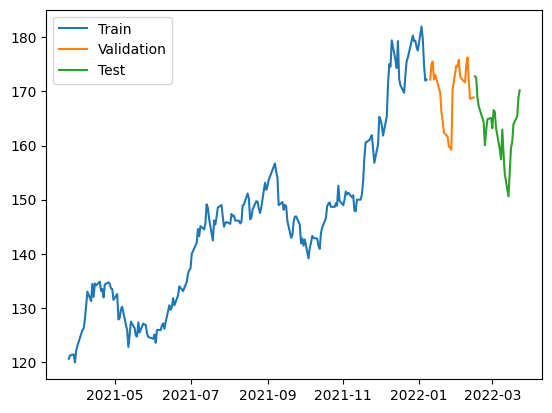

In [8]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150)

Epoch 1/150
7/7 [==============================] - 4s 146ms/step - loss: 21021.7656 - mean_absolute_error: 144.1946 - val_loss: 28387.4648 - val_mean_absolute_error: 168.3981
Epoch 2/150
7/7 [==============================] - 0s 12ms/step - loss: 20840.7812 - mean_absolute_error: 143.5658 - val_loss: 28165.0566 - val_mean_absolute_error: 167.7363
Epoch 3/150
7/7 [==============================] - 0s 12ms/step - loss: 20625.7012 - mean_absolute_error: 142.8152 - val_loss: 27871.4922 - val_mean_absolute_error: 166.8588
Epoch 4/150
7/7 [==============================] - 0s 12ms/step - loss: 20335.1016 - mean_absolute_error: 141.7926 - val_loss: 27458.0508 - val_mean_absolute_error: 165.6151
Epoch 5/150
7/7 [==============================] - 0s 16ms/step - loss: 19907.4297 - mean_absolute_error: 140.2670 - val_loss: 26824.6855 - val_mean_absolute_error: 163.6917
Epoch 6/150
7/7 [==============================] - 0s 18ms/step - loss: 19266.7832 - mean_absolute_error: 137.9663 - val_loss: 25

7/7 [==============================] - 0s 3ms/step


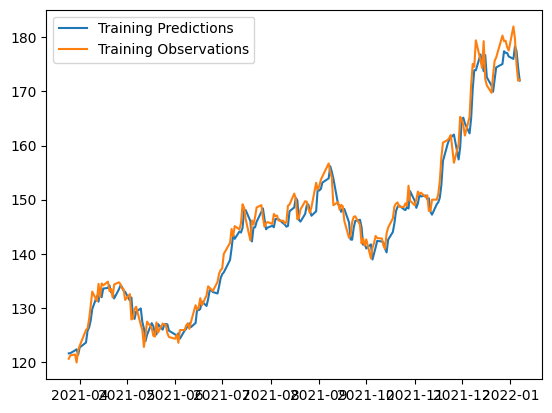

In [10]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 25ms/step


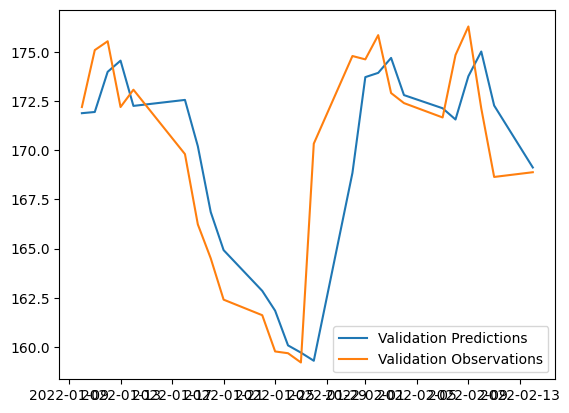

In [11]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 20ms/step


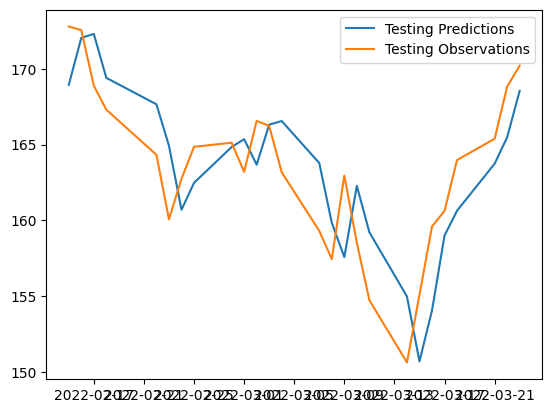

In [12]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

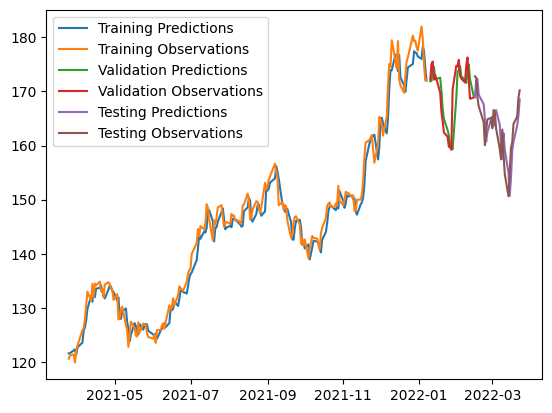

In [13]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [14]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction
  

1/1 [==============================] - 0s 27ms/step


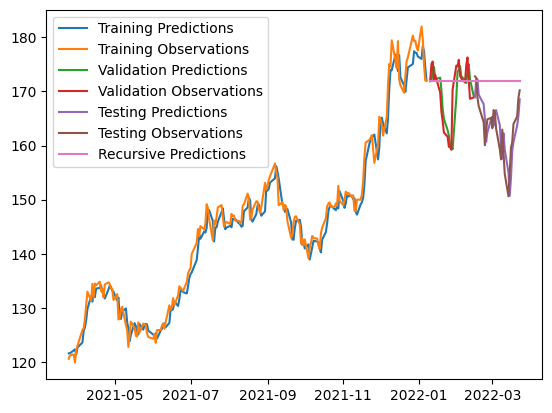

In [15]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])